<a href="https://colab.research.google.com/github/sycoraxx/news-article-classification/blob/main/DistillBERT_Pipeline_for_News_Article_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch]

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download rmisra/news-category-dataset

news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/news-category-dataset.zipn

unzip:  cannot find or open /content/news-category-dataset.zipn, /content/news-category-dataset.zipn.zip or /content/news-category-dataset.zipn.ZIP.


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.7
TEST_SIZE = 0.15
VAL_SIZE = 0.15

from sklearn.metrics import accuracy_score
import seaborn as sns

import torch
import torch.nn.functional as F
import torchtext
from transformers import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import os
# print(os.listdir("../input"))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda'

In [10]:
data = pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [11]:
data.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

As you might have realized, some categories are pretty much the same:
* 'WORLDPOST' || 'THE WORLDPOST'
* 'PARENTS' || 'PARENTING'
* 'ARTS' || 'ARTS & CULTURE' || 'CULTURE & ARTS'
* 'STYLE & BEAUTY' || 'STYLE'
* 'EDUCATION' || 'COLLEGE'
* 'TASTE' || 'FOOD & DRINK'

In [12]:
def category_cleaner(x):
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    else:
        return x

data['category'] = data.category.apply(category_cleaner)
le = LabelEncoder()
data_labels = le.fit_transform(data.category)
list(le.classes_)

['ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'CRIME',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TECH',
 'TRAVEL',
 'U.S. NEWS',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

In [13]:
def plot_piechart(data=pd.DataFrame):
    plt.figure(figsize=(10,10))
    sizes = data.category.value_counts().values
    labels = data.category.value_counts().index
    plt.pie(sizes, labels=labels, autopct='%.1f%%',
        shadow=True, pctdistance=0.85, labeldistance=1.05, startangle=20,
        explode = [0 if i > 0 else 0.2 for i in range(len(sizes))])
    plt.axis('equal')
    plt.show()

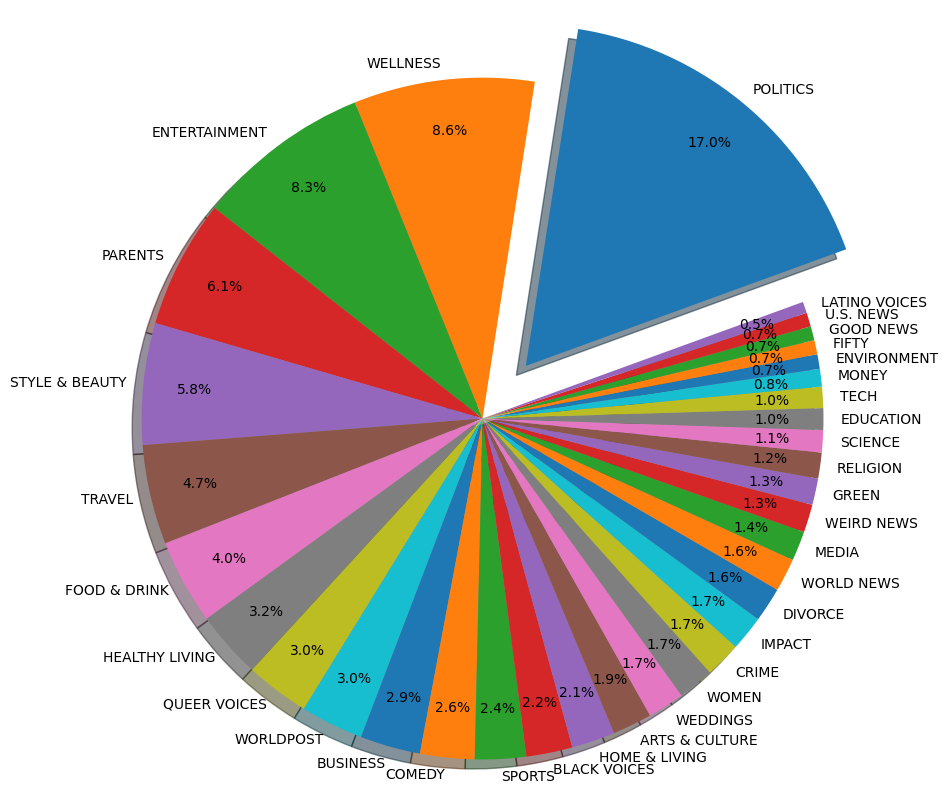

In [14]:
plot_piechart(data)

In [15]:
def plot_histclasscounts(data=pd.DataFrame):

    class_counts = data.category.value_counts()
    plt.figure(figsize=(10, 10))
    class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Counts Histogram')

    # Show the plot
    plt.show()

In [16]:
data.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTS', 'WORLD NEWS', 'ARTS & CULTURE',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'GREEN', 'HEALTHY LIVING', 'WORLDPOST', 'GOOD NEWS', 'FIFTY',
       'DIVORCE'], dtype=object)

In [17]:
data["label"] = data_labels

####  Resampling Data

In [18]:
data.head()

,link,headline,category,short_description,authors,date,label
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,28
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,28
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,3
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTS,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,19
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,28


In [19]:
data = data.drop(columns = ['authors', 'date', 'link'], axis=1)

In [20]:
resampled_data = data.sample(n=50000, random_state=42)

In [21]:
resampled_data.head()

,headline,category,short_description,label
128310,What If We Were All Family Generation Changers?,IMPACT,"What if, in doing so, we won't just create new...",15
139983,Firestorm At AOL Over Employee Benefit Cuts,BUSINESS,It should have been a glorious week for AOL ch...,2
42339,Dakota Access Protesters Arrested As Deadline ...,POLITICS,A few protesters who refused to leave remained...,20
131494,One Glimpse Of These Baby Kit Foxes And You'll...,GREEN,,12
163649,"Mens' Sweat Pheromone, Androstadienone, Influe...",SCIENCE,Scientists didn't know if humans played that g...,23


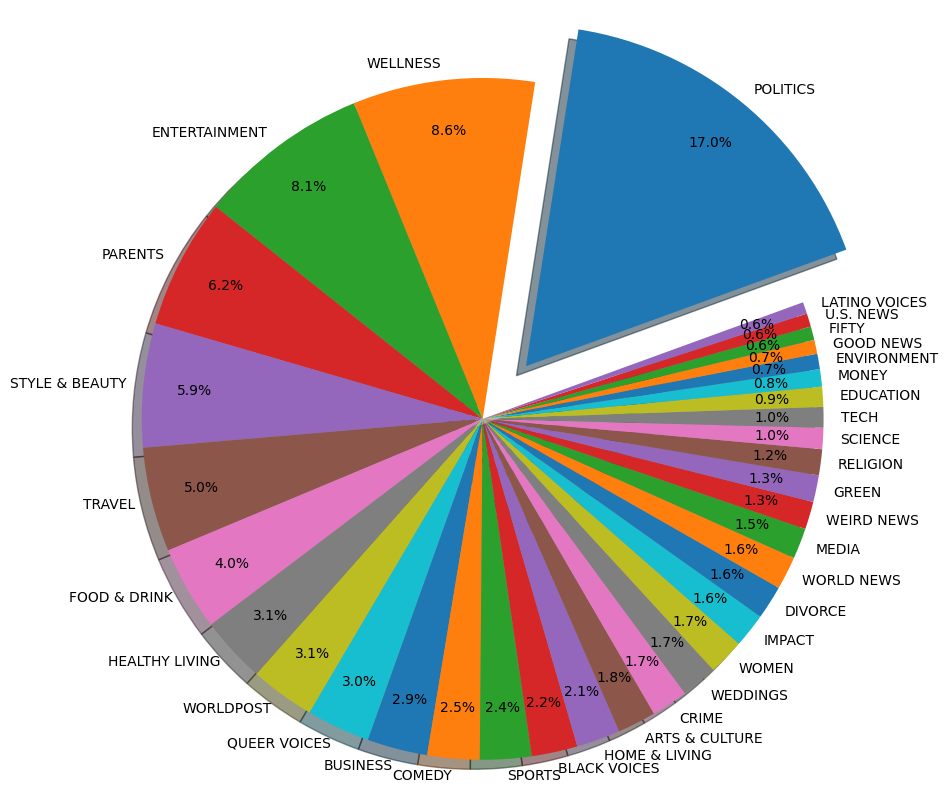

In [22]:
plot_piechart(resampled_data)

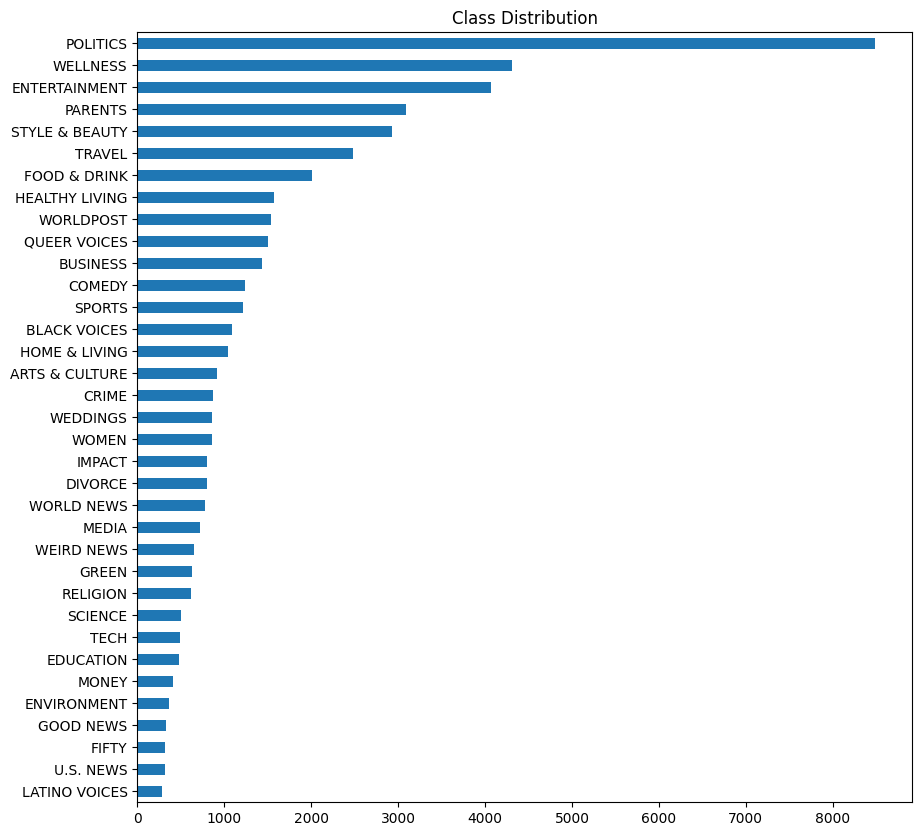

In [23]:
plt.figure(figsize=(10, 10))
resampled_data['category'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

In [24]:
resampled_data["text"] = resampled_data["headline"] + " " + resampled_data["short_description"]

In [25]:
resampled_data.head(5)

,headline,category,short_description,label,text
128310,What If We Were All Family Generation Changers?,IMPACT,"What if, in doing so, we won't just create new...",15,What If We Were All Family Generation Changers...
139983,Firestorm At AOL Over Employee Benefit Cuts,BUSINESS,It should have been a glorious week for AOL ch...,2,Firestorm At AOL Over Employee Benefit Cuts It...
42339,Dakota Access Protesters Arrested As Deadline ...,POLITICS,A few protesters who refused to leave remained...,20,Dakota Access Protesters Arrested As Deadline ...
131494,One Glimpse Of These Baby Kit Foxes And You'll...,GREEN,,12,One Glimpse Of These Baby Kit Foxes And You'll...
163649,"Mens' Sweat Pheromone, Androstadienone, Influe...",SCIENCE,Scientists didn't know if humans played that g...,23,"Mens' Sweat Pheromone, Androstadienone, Influe..."


<Figure size 1500x1500 with 0 Axes>

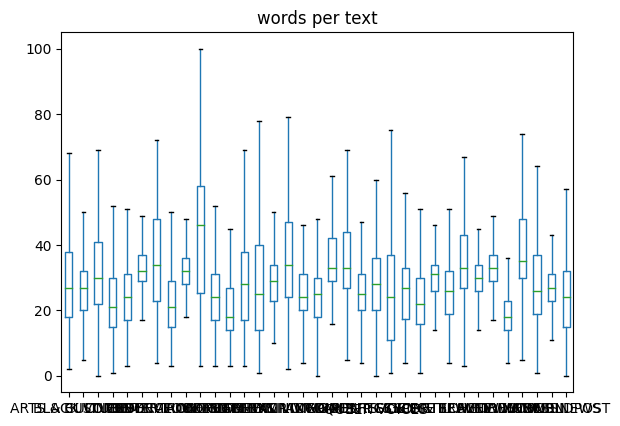

In [26]:
plt.figure(figsize=(15, 15))
resampled_data['words per text'] = resampled_data['text'].str.split().apply(len)
resampled_data.boxplot('words per text', by='category', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
import re
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower case
    text = text.lower()

    # Remove links from text data
    text = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',text)

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    ext = pattern.sub("", text)

    # Spacing and filters
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

In [29]:
resampled_data['text'].iloc[0]

"What If We Were All Family Generation Changers? What if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover ways to create new opportunities for our families that may not have otherwise existed?"

In [30]:
preprocess(text = resampled_data['text'].iloc[5])

'summer sleepover tips here are five ways to get some beauty sleep while hosting a sleepover for your child.'

In [31]:
# Apply to dataframe
preprocessed_df = resampled_data.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
print(f"{resampled_data.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

What If We Were All Family Generation Changers? What if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover ways to create new opportunities for our families that may not have otherwise existed?

what if we were all family generation changers? what if, in doing so, we won't just create new opportunities for ourselves, we'll also uncover ways to create new opportunities for our families that may not have otherwise existed?


In [32]:
preprocessed_df = preprocessed_df.reset_index()
preprocessed_df = preprocessed_df.drop(columns = ['headline', 'index', 'short_description'], axis=1)
preprocessed_df.head(5)


,category,label,text,words per text
0,IMPACT,15,what if we were all family generation changers...,38
1,BUSINESS,2,firestorm at aol over employee benefit cuts it...,26
2,POLITICS,20,dakota access protesters arrested as deadline ...,22
3,GREEN,12,one glimpse of these baby kit foxes and you'll...,11
4,SCIENCE,23,"mens' sweat pheromone, androstadienone, influe...",31


In [33]:
len(le.classes_), len(preprocessed_df.category.unique())

(35, 35)

In [34]:
X = preprocessed_df.text.values
y = preprocessed_df.label.values

In [35]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [36]:
encoded_text = tokenizer('Tokenizing text is a core task in NLP')
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [37]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'in',
 'nl',
 '##p',
 '[SEP]']

In [38]:
words = tokenizer.convert_ids_to_tokens(tokenizer('embedding').input_ids)
print(words)
print(tokenizer.convert_tokens_to_string(words))

['[CLS]', 'em', '##bed', '##ding', '[SEP]']
[CLS] embedding [SEP]


In [39]:
print('The vocabulary size is:', tokenizer.vocab_size)

The vocabulary size is: 30522


In [40]:
print('Maximum context size:', tokenizer.model_max_length)

Maximum context size: 512


In [41]:
print('Name of the fields, model need in the forward pass:', tokenizer.model_input_names)

Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [42]:
def train_val_test_split(X, y, train_size=TRAIN_SIZE):
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [43]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

In [44]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

print(f"Sample point: {X_train[0]} → {le.inverse_transform([y_train[0]])}")

X_train: (35000,), y_train: (35000,)
X_test: (7500,), y_test: (7500,)
X_val: (7500,), y_val: (7500,)
Sample point: jake johnson channels his larger-than-life family in netflix's 'win it all' the "new girl" star plays a small-time gambler in the new movie. → ['ENTERTAINMENT']


In [45]:
encoded_input = tokenizer(X_train[0], truncation=True, padding=True, return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[  101,  5180,  3779,  6833,  2010,  3469,  1011,  2084,  1011,  2166,
          2155,  1999, 20907,  1005,  1055,  1005,  2663,  2009,  2035,  1005,
          1996,  1000,  2047,  2611,  1000,  2732,  3248,  1037,  2235,  1011,
          2051, 18503,  2099,  1999,  1996,  2047,  3185,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [46]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

In [47]:
train_encodings

{'input_ids': tensor([[  101,  5180,  3779,  ...,     0,     0,     0],
        [  101,  2969,  1011,  ...,     0,     0,     0],
        [  101, 28493, 11404,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  4518,  ...,     0,     0,     0],
        [  101, 14689, 10196,  ...,     0,     0,     0],
        [  101,  2129,  2000,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [48]:
import torch

class NewsCategoryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsCategoryDataset(train_encodings, y_train)
val_dataset = NewsCategoryDataset(val_encodings, y_val)
test_dataset = NewsCategoryDataset(test_encodings, y_test)

In [49]:
train_dataset[0]

<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'input_ids': tensor([  101,  5180,  3779,  6833,  2010,  3469,  1011,  2084,  1011,  2166,
          2155,  1999, 20907,  1005,  1055,  1005,  2663,  2009,  2035,  1005,
          1996,  1000,  2047,  2611,  1000,  2732,  3248,  1037,  2235,  1011,
          2051, 18503,  2099,  1999,  1996,  2047,  3185,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [51]:
len(test_dataset)
train_dataset[2]

<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'input_ids': tensor([  101, 28493, 11404,  2758,  2045,  1005,  1055,  1005,  2053,  2951,
          1005,  2000,  2490,  1996, 11262,  3466,  1996,  4905,  2236,  2056,
          1996,  6594,  2055, 21107,  2069,  3084,  2149,  2035, 13726,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda'

In [53]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_), )
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [55]:
!pip install accelerate -U

In [56]:
from transformers import Trainer, TrainingArguments

model.train()

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    fp16=True
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset           # evaluation dataset
)

trainer.train()

<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,3.520100
20,3.535100
30,3.522900
40,3.494100
50,3.474000
60,3.441600
70,3.396200
80,3.410700
90,3.303400
100,3.239600


<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a 

TrainOutput(global_step=10940, training_loss=0.7145533619349792, metrics={'train_runtime': 2278.8787, 'train_samples_per_second': 76.792, 'train_steps_per_second': 4.801, 'total_flos': 1.300212997125e+16, 'train_loss': 0.7145533619349792, 'epoch': 5.0})

In [57]:
torch.cuda.empty_cache()

In [58]:
def compute_accuracy(model, data_loader, device=device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [59]:
model.eval()
model.to(device)

print(f'Test accuracy: {compute_accuracy(model, test_loader, device):.2f}%')

<ipython-input-48-e953316a6aff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test accuracy: 68.01%


In [60]:
!pip install transformers[onnx]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 713.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [61]:
# Save output to local checkpoint
tokenizer.save_pretrained("local-pt-checkpoint")
model.save_pretrained("local-pt-checkpoint")

In [63]:
# convert the local check point to onnx
import subprocess
subprocess.run(f"python -m transformers.onnx --model=local-pt-checkpoint --feature=sequence-classification onnx/".split())

CompletedProcess(args=['python', '-m', 'transformers.onnx', '--model=local-pt-checkpoint', '--feature=sequence-classification', 'onnx/'], returncode=1)

In [64]:
model.save_pretrained("/content/")

In [65]:
tokenizer.save_pretrained("/content/")

('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')